# TUGAS BESAR
IF5153 Pemrosesan Bahasa Alami

## Model Analisis Promo di Media Sosial (X)
### Model Klasifikasi Promo/Non-Promo - Fine Tuning IndoLM/IndoBERT
Nama : Husnia Munzayana <br>
NIM  : 13521077

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pandas numpy matplotlib scikit-learn seaborn
!pip install Sastrawi nltk
!pip install transformers torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 7.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import seaborn as sns
import re
import nltk
import string
import torch
import os

# Data Loading and Exploration

In [4]:
data = pd.read_csv('https://raw.githubusercontent.com/jejejery/IF5153-Tugas-Besar-Analisis-Promo/refs/heads/main/data/new_dataset_combine_promo_nonpromo_labeled.tsv', sep='\t')

In [5]:
print("\nMissing Values:")
print(data.isnull().sum())

# Check for duplicates
duplicates = data.duplicated().sum()
print(f"\nNumber of Duplicate Rows: {duplicates}")

if duplicates > 0:
    print("\nPreview of Duplicate Rows:")
    print(data[data.duplicated()].head())

data = data.drop_duplicates()


Missing Values:
full_text         0
label_promo       0
label_category    0
dtype: int64

Number of Duplicate Rows: 1

Preview of Duplicate Rows:
                                             full_text  label_promo  \
596  Njirrr kode promo gojek udh pada gak bisa kah,...            0   

     label_category  
596              -1  


In [6]:
print("\nBasic Information:")
print(data.info())

print(f"\nDataset size: {data.shape[0]} rows and {data.shape[1]} columns.")


Basic Information:
<class 'pandas.core.frame.DataFrame'>
Index: 679 entries, 0 to 679
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   full_text       679 non-null    object
 1   label_promo     679 non-null    int64 
 2   label_category  679 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 21.2+ KB
None

Dataset size: 679 rows and 3 columns.


In [7]:
data.head()

,full_text,label_promo,label_category
0,@mwanual Haloo yuk jajan layout di @parkyoriii...,1,6
1,@raihanaulia_rar Ah iya Lotte dulu kesini buat...,1,0
2,@tokopedia yang paling ku tungguinnn ° ° Disko...,1,6
3,[Promo Pagiii] Promo Shopee Food hari ini disk...,1,0
4,100% kulit sapi segar 100% bebas pemutih 100% ...,1,6


In [8]:
print("\nMissing Values:")
print(data.isnull().sum())

# Check for duplicates
duplicates = data.duplicated().sum()
print(f"\nNumber of Duplicate Rows: {duplicates}")

if duplicates > 0:
    print("\nPreview of Duplicate Rows:")
    print(data[data.duplicated()].head())

data = data.drop_duplicates()


Missing Values:
full_text         0
label_promo       0
label_category    0
dtype: int64

Number of Duplicate Rows: 0



Label Distribution (Counts and Percentages):
label_promo
1    508
0    171
Name: count, dtype: int64
label_promo
1    74.815906
0    25.184094
Name: count, dtype: float64


<ipython-input-9-5e603a1b876f>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


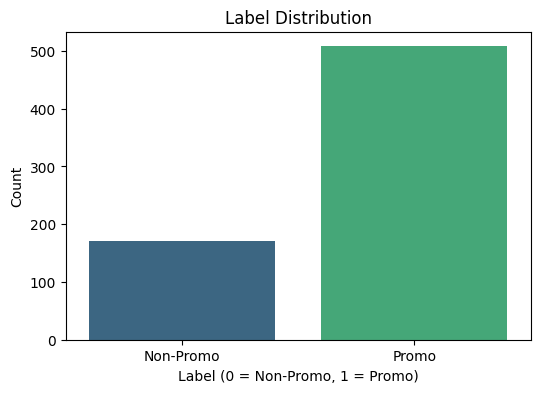

In [9]:
# Label distribution
label_counts = data['label_promo'].value_counts()
print("\nLabel Distribution (Counts and Percentages):")
print(label_counts)
print(label_counts / len(data) * 100)

# Visualize
plt.figure(figsize=(6, 4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title("Label Distribution")
plt.xlabel("Label (0 = Non-Promo, 1 = Promo)")
plt.ylabel("Count")
plt.xticks([0, 1], ['Non-Promo', 'Promo'])
plt.show()


Word Count Statistics:
count    679.000000
mean      27.217968
std       11.497578
min        3.000000
25%       18.000000
50%       26.000000
75%       36.000000
max      109.000000
Name: word_count, dtype: float64


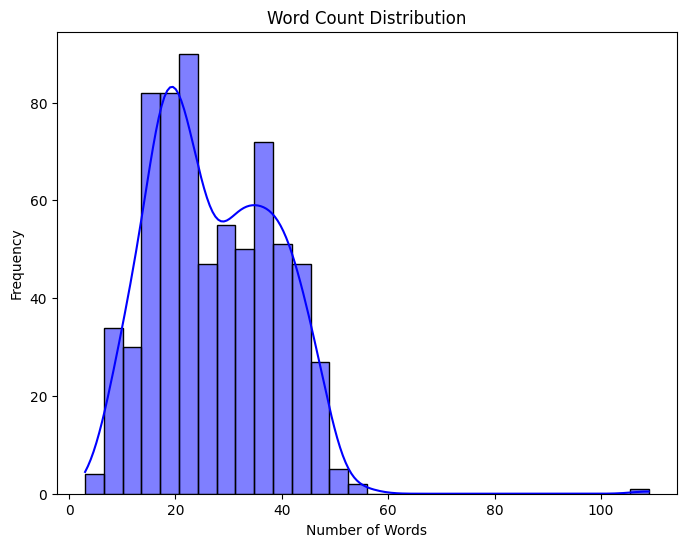

In [10]:
# Add a column for word count
data['word_count'] = data['full_text'].apply(lambda x: len(x.split()))

print("\nWord Count Statistics:")
print(data['word_count'].describe())

# Visualize word count distribution
plt.figure(figsize=(8, 6))
sns.histplot(data['word_count'], bins=30, kde=True, color='blue')
plt.title("Word Count Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


Most Common Words:
[('di', 418), ('promo', 290), ('diskon', 241), ('dan', 171), ('untuk', 164), ('Harga', 147), ('Produk:', 131), ('Promo', 130), ('beli', 114), ('-', 107), ('Diskon', 102), ('dengan', 100), ('ada', 99), ('murah', 95), ('Yuk', 90), ('harga', 89), ('dari', 88), ('Dapatkan', 85), ('bisa', 83), ('|', 81)]


<ipython-input-11-9fcb808b5312>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis')


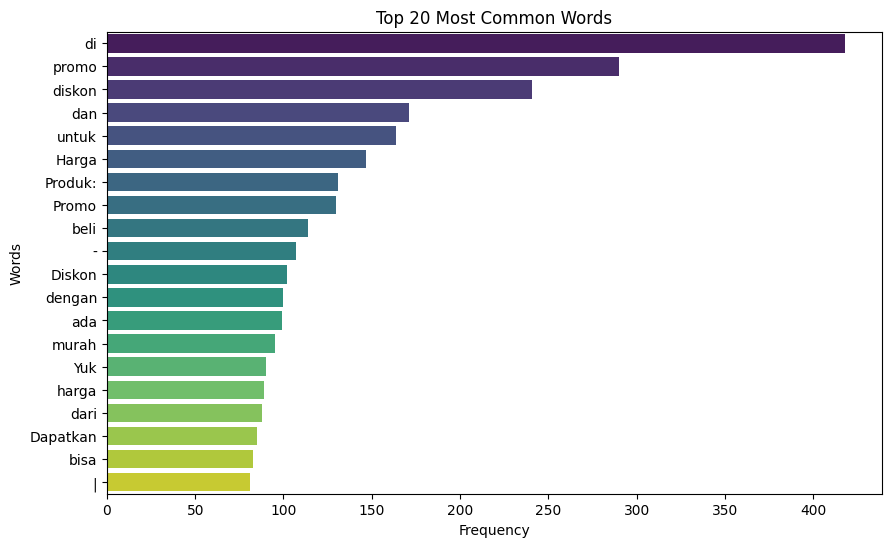

In [11]:
from collections import Counter

# Tokenize and count words
all_words = ' '.join(data['full_text']).split()
most_common_words = Counter(all_words).most_common(20)

print("\nMost Common Words:")
print(most_common_words)

# Visualize most common words
words, counts = zip(*most_common_words)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(counts), y=list(words), palette='viridis')
plt.title("Top 20 Most Common Words")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()

# Data Pre-Processing

In [12]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

factory = StemmerFactory()
stemmer = factory.create_stemmer()

stopwords_id = set(stopwords.words('indonesian'))

def process_text(text):
    # Lowercase
    text = text.lower()

    # Entity masking
    # URLs Masking
    text = re.sub(r'http\S+|www\S+', '_url_', text)

    # Usernames Masking
    text = re.sub(r'@\w+', '_username_', text)

    # Hashtags Masing
    text = re.sub(r'#\w+', '_hashtag_', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenization
    tokens = word_tokenize(text)

    # Stopwords elimination
    tokens = [word for word in tokens if word not in stopwords_id]

    # # Stemming
    # tokens = [stemmer.stem(word) for word in tokens]

    return tokens

def preprocess_texts(texts):
    processed_texts = []
    for text in tqdm(texts, desc="Preprocessing Texts"):
        tokens = process_text(text)
        processed_texts.append(tokens)
    return processed_texts

tqdm.pandas()
data['clean_tweet'] = data['full_text'].progress_apply(process_text)

print("\nPreview data after preprocessing:")
print(data[['full_text', 'clean_tweet', 'label_promo']].head())


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
100%|██████████| 679/679 [00:00<00:00, 2275.84it/s]


Preview data after preprocessing:
                                           full_text  \
0  @mwanual Haloo yuk jajan layout di @parkyoriii...   
1  @raihanaulia_rar Ah iya Lotte dulu kesini buat...   
2  @tokopedia yang paling ku tungguinnn ° ° Disko...   
3  [Promo Pagiii] Promo Shopee Food hari ini disk...   
4  100% kulit sapi segar 100% bebas pemutih 100% ...   

                                         clean_tweet  label_promo  
0  [username, haloo, yuk, jajan, layout, username...            1  
1  [username, ah, iya, lotte, kesini, belanja, ba...            1  
2  [username, ku, tungguinnn, °, °, diskon, 30, °...            1  
3  [promo, pagiii, promo, shopee, food, diskon, 8...            1  
4  [100, kulit, sapi, segar, 100, bebas, pemutih,...            1  


## Data Splitting

In [13]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    data['clean_tweet'].apply(lambda x: ' '.join(x)),
    data['label_promo'],
    test_size=0.2,
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.25,
    random_state=42
)

print(f"Data Train: {len(X_train)}, Data Validation: {len(X_val)}, Data Test: {len(X_test)}")


Data Train: 407, Data Validation: 136, Data Test: 136


In [14]:
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label_promo': torch.tensor(label, dtype=torch.long)
        }

# Modelling

In [15]:
model_name = "indolem/indobert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_dataset = TweetDataset(X_train, y_train, tokenizer)
val_dataset = TweetDataset(X_val, y_val, tokenizer)
test_dataset = TweetDataset(X_test, y_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/234k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [16]:
# Load Model and Optimizer
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

# Training and Evaluation Functions
def train_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    loop = tqdm(dataloader, desc="Training")
    for batch in loop:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label_promo'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        predictions = torch.argmax(logits, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
    return total_loss / len(dataloader), correct / total

def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label_promo'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            total_loss += loss.item()
            predictions = torch.argmax(logits, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    return total_loss / len(dataloader), correct / total

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [17]:
epochs = 5
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)
    print(f"\nTrain Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")

    val_loss, val_acc = evaluate(model, val_loader, device)
    print(f"\nValidation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")


Epoch 1/5


Training: 100%|██████████| 26/26 [00:09<00:00,  2.83it/s]



Train Loss: 0.4992, Train Accuracy: 0.7494


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 10.44it/s]



Validation Loss: 0.3250, Validation Accuracy: 0.9191
Epoch 2/5


Training: 100%|██████████| 26/26 [00:07<00:00,  3.25it/s]



Train Loss: 0.2446, Train Accuracy: 0.9091


Evaluating: 100%|██████████| 9/9 [00:00<00:00,  9.89it/s]



Validation Loss: 0.1785, Validation Accuracy: 0.9265
Epoch 3/5


Training: 100%|██████████| 26/26 [00:08<00:00,  3.19it/s]



Train Loss: 0.1601, Train Accuracy: 0.9287


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 10.11it/s]



Validation Loss: 0.1317, Validation Accuracy: 0.9632
Epoch 4/5


Training: 100%|██████████| 26/26 [00:08<00:00,  3.16it/s]



Train Loss: 0.1085, Train Accuracy: 0.9656


Evaluating: 100%|██████████| 9/9 [00:00<00:00,  9.92it/s]



Validation Loss: 0.2641, Validation Accuracy: 0.8897
Epoch 5/5


Training: 100%|██████████| 26/26 [00:08<00:00,  3.13it/s]



Train Loss: 0.1280, Train Accuracy: 0.9459


Evaluating: 100%|██████████| 9/9 [00:00<00:00,  9.32it/s]


Validation Loss: 0.1703, Validation Accuracy: 0.9485


In [18]:
test_loss, test_acc = evaluate(model, test_loader, device)
print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Evaluating: 100%|██████████| 9/9 [00:00<00:00,  9.33it/s]


Test Loss: 0.0885, Test Accuracy: 0.9485


In [19]:
predictions, true_labels = [], []
model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label_promo'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print(classification_report(true_labels, predictions, target_names=['Non-Promo', 'Promo']))

              precision    recall  f1-score   support

   Non-Promo       0.93      0.84      0.89        32
       Promo       0.95      0.98      0.97       104

    accuracy                           0.95       136
   macro avg       0.94      0.91      0.93       136
weighted avg       0.95      0.95      0.95       136



In [20]:
output_dir = '/content/drive/MyDrive/TUGAS KULIAH/TUGAS BESAR NLP/MODEL/Promo-Non Classification/Indolem-IndoBERT'

os.makedirs(output_dir, exist_ok=True)
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print("Model and tokenizer saved successfully.")

Model and tokenizer saved successfully.
